<a href="https://colab.research.google.com/github/anonyms/Kagggle_DigitRecognizer/blob/master/Kaggle_Digit_Recognizer_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Needed Imports

In [0]:
import numpy as np 
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Lambda, Conv2D, Dropout, BatchNormalization, Convolution2D , MaxPooling2D, MaxPool2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

from google.colab import files
from google.colab import data_table
seed = 4

Preparing folders

In [0]:
recognizer_data_loctaion = "~/data/datarecognizer/"
submission_file_name = "submissions.csv"
submission_file_location = recognizer_data_loctaion + submission_file_name
!mkdir ~/data

Kaggle Set-up

In [0]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anoynms","key":"4b2c6afaefabfef48178035ff45d414b"}'}

In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c digit-recognizer -p $recognizer_data_loctaion

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 95.8MB/s]
  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 84.1MB/s]
  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 56.2MB/s]


In [0]:
## Check files are there
!ls -l $recognizer_data_loctaion

total 15856
-rw-r--r-- 1 root root  240909 Apr  7 11:59 sample_submission.csv
-rw-r--r-- 1 root root 6385593 Apr  7 11:59 test.csv.zip
-rw-r--r-- 1 root root 9606023 Apr  7 11:59 train.csv.zip


Import data from files

In [0]:
train_file_location = recognizer_data_loctaion + "train.csv"
test_file_location =recognizer_data_loctaion + "test.csv" 
!unzip $train_file_location
!unzip $test_file_location

Archive:  /root/data/datarecognizer/train.csv.zip
  inflating: train.csv               
Archive:  /root/data/datarecognizer/test.csv.zip
  inflating: test.csv                


In [0]:
train = pd.read_csv(recognizer_data_loctaion + "train.csv.zip")
test = pd.read_csv(recognizer_data_loctaion + "test.csv.zip")
output_sample = pd.read_csv(recognizer_data_loctaion + "sample_submission.csv")

In [0]:
train_copy = train.copy()
y = train_copy['label'].reset_index(drop=True)
train_features = train_copy.drop(['label'],axis=1)
features = pd.concat([train_features, test]).reset_index(drop=True)

In [0]:
train.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [0]:
def data_prep(test,num_classes,num_images,img_cols):
    num_images = test.shape[0]
    x_as_array = test.values
    x_shaped_array = x_as_array.reshape(num_images, img_rows, img_cols,1)
    out_x = x_shaped_array / 255
    return out_x

def standardize(x): 
    return (x-mean_px)/std_px

In [0]:
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
y_train= to_categorical(y_train)
num_classes = y_train.shape[1]

img_rows, img_cols = 28, 28
X_train = data_prep(train.iloc[:,1:],num_classes,28,28)
X_test = data_prep(test,num_classes,28,28)

In [0]:
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=random_seed)

In [0]:
## After multiple attempts, copied verison from this notebook that worked best:
## https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [0]:
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [0]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 3 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 128

In [0]:
## First attempt with new attemt - score: 0.98300
##model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), verbose = 2)
##predictions = model.predict(X_test)
##predictions = np.argmax(predictions,axis=1)

440/440 - 243s - loss: 0.2358 - accuracy: 0.9239 - val_loss: 0.0629 - val_accuracy: 0.9814


In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [0]:
model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/3
295/295 - 248s - loss: 0.1814 - accuracy: 0.9457 - val_loss: 0.0583 - val_accuracy: 0.9840 - lr: 0.0010
Epoch 2/3
295/295 - 250s - loss: 0.1043 - accuracy: 0.9696 - val_loss: 0.0378 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 3/3
295/295 - 246s - loss: 0.0786 - accuracy: 0.9765 - val_loss: 0.0328 - val_accuracy: 0.9902 - lr: 0.0010


In [0]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions,axis=1)

KeyError: ignored

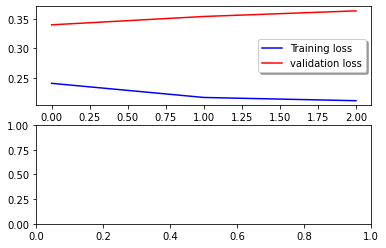

In [0]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

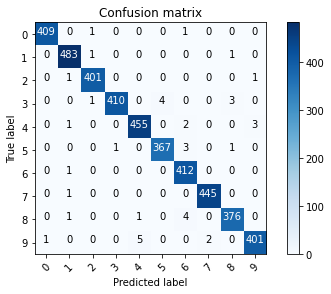

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))


Submission part
---



In [0]:
submission = pd.read_csv(recognizer_data_loctaion + "sample_submission.csv")
submission.iloc[:,1] = predictions
submission.head(15)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [0]:
submission.iloc[:,1]

0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

In [0]:
submission.to_csv(submission_file_location, index=False)
!head $submission_file_location

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


In [0]:
comment = input("Enter what comment to put with the Kaggle commit")
comment ="\""+comment+"\""
!kaggle competitions submit -c digit-recognizer -f $submission_file_location -m $comment

Enter what comment to put with the Kaggle commitFinal 4th attempt with Image Generator
100% 208k/208k [00:00<00:00, 803kB/s]
Successfully submitted to Digit Recognizer